# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [ ]:
import tensorflow as tf

from tqdm import tqdm_notebook

# from tqdm import tqdm.notebook.tqdm

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170498071/170498071 [==============================] - 6s 0us/step
(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

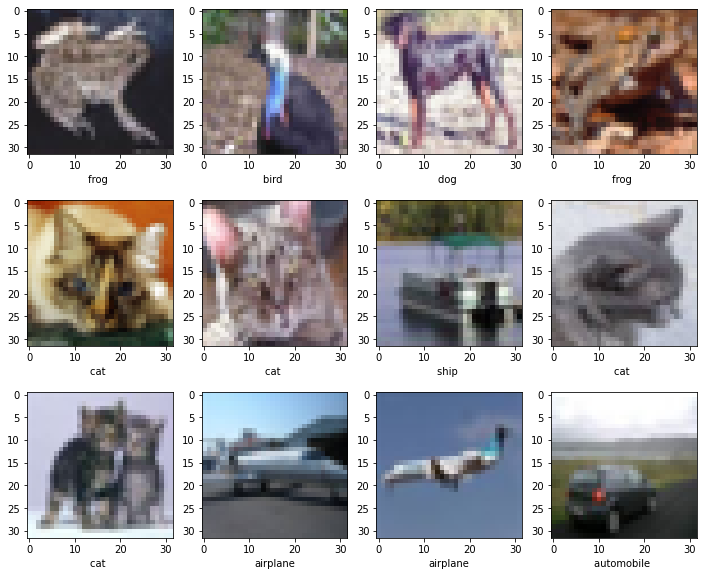

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers as L
from keras import backend as K
from tensorflow.keras.models import Sequential

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 32)                3

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 487ms/step
Успех!


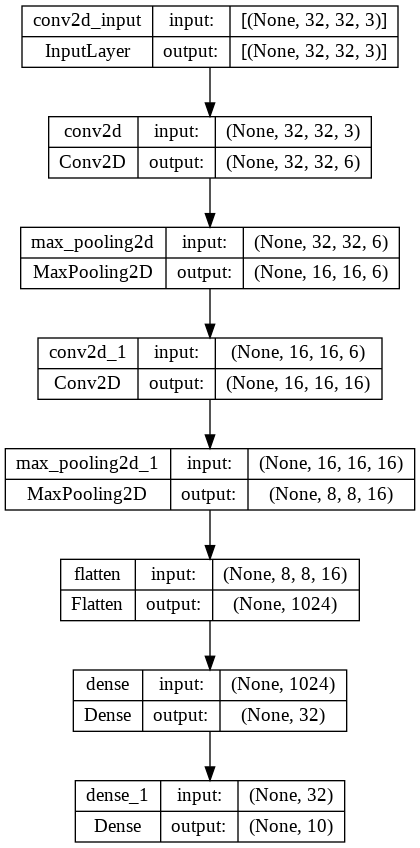

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs')]

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks)

Epoch 1/30
1250/1250 [==============================] - 51s 40ms/step - loss: 1.6970 - accuracy: 0.3873 - val_loss: 1.4712 - val_accuracy: 0.4737
Epoch 2/30
1250/1250 [==============================] - 44s 35ms/step - loss: 1.3719 - accuracy: 0.5125 - val_loss: 1.3921 - val_accuracy: 0.5066
Epoch 3/30
1250/1250 [==============================] - 41s 33ms/step - loss: 1.2567 - accuracy: 0.5574 - val_loss: 1.2267 - val_accuracy: 0.5670
Epoch 4/30
1250/1250 [==============================] - 40s 32ms/step - loss: 1.1773 - accuracy: 0.5888 - val_loss: 1.1814 - val_accuracy: 0.5820
Epoch 5/30
1250/1250 [==============================] - 40s 32ms/step - loss: 1.1219 - accuracy: 0.6040 - val_loss: 1.1788 - val_accuracy: 0.5862
Epoch 6/30
1250/1250 [==============================] - 40s 32ms/step - loss: 1.0752 - accuracy: 0.6218 - val_loss: 1.1033 - val_accuracy: 0.6136
Epoch 7/30
1250/1250 [==============================] - 41s 32ms/step - loss: 1.0397 - accuracy: 0.6355 - val_loss: 1.0814 -

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test,np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 4s 12ms/step

 Test_acc = 0.6259
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 10)        280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               256100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 257,390
Trainable params: 257,390
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/30
625/625 [==============================] - 18s 28ms/step - loss: 1.7258 - accuracy: 0.3837 - val_loss: 1.5287 - val_accuracy: 0.4565
Epoch 2/30
625/625 [==============================] - 18s 29ms/step - loss: 1.4606 - accuracy: 0.4839 - val_loss: 1.4368 - val_accuracy: 0.4850
Epoch 3/30
625/625 [==============================] - 18s 29ms/step - loss: 1.3499 - accuracy: 0.5255 - val_loss: 1.3407 - val_accuracy: 0.5241
Epoch 4/30
625/625 [==============================] - 18s 28ms/step - loss: 1.2615 - accuracy: 0.5562 - val_loss: 1.2769 - val_accuracy: 0.5515
Epoch 5/30
625/625 [==============================] - 18s 30ms/step - loss: 1.2011 - accuracy: 0.5773 - val_loss: 1.2713 - val_accuracy: 0.5573
Epoch 6/30
625/625 [==============================] - 18s 29ms/step - loss: 1.1566 - accuracy: 0.5945 - val_loss: 1.2165 - val_accuracy: 0.5673
Epoch 7/30
625/625 [==============================] - 19s 30ms/step - loss: 1.1152 - accuracy: 0.6088 - val_loss: 1.2252 - val_accuracy:

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 2s 7ms/step

 Test_acc = 0.6028
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict_classes(X_test))))

In [ ]:
!rm -rf ./logs

In [ ]:
optimizers = {
    'Adadelta': 'Adadelta',
    'Adagrad': 'Adagrad',
    'Adamax': 'Adamax',
    'Ftrl': 'Ftrl',
    'Nadam': 'Nadam',
    'sgd': 'sgd',
    'RMSprop': 'RMSprop',
    'Adam': 'Adam'
}

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

**7 с половиной часов и выполнено меньше половины. Да чтоб вам эти сети снились**

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from tensorflow.keras import optimizers as O

optimizers = {
    'Adam': O.Adam(),
    'SGD': O.SGD(),
    'RMSprop': O.RMSprop()
}

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
model_1_4 = Sequential([
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            input_shape=(32, 32, 3)),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dropout(0.3),       
    L.Dense(100, activation='relu'),
    L.Dropout(0.3),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')
    ])

In [ ]:
model_1_4.compile(
    loss='categorical_crossentropy',
    optimizer=O.SGD(),
    metrics=["accuracy"])

In [ ]:
callbacks_1_4 =[
    keras.callbacks.EarlyStopping(
    monitor ="val_accuracy",
    patience=2,
    verbose=2,
    mode="max",
    restore_best_weights=True
   )
    ]

In [ ]:
predict_x = model_1_4.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)

313/313 [==============================] - 3s 8ms/step

 Test_acc = 0.1


In [ ]:
model_2_4 = Sequential([
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            input_shape=(32, 32, 3)),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'),
    L.MaxPool2D(pool_size=(2, 2), padding='valid'),
    L.BatchNormalization(),
    L.Flatten(),
    L.Dropout(0.3),       
    L.Dense(100, activation='relu'),
    L.Dropout(0.3),
    L.Dense(100, activation='relu'),
    L.BatchNormalization(),
    L.Dense(10, activation='softmax')])

In [ ]:
model_2_4.compile(
    loss='categorical_crossentropy',
    optimizer=O.SGD(),
    metrics=["accuracy"])

In [ ]:
model_2_4.fit(X_train, y_train, batch_size=32, epochs=7, verbose=1, callbacks=callbacks_1_4, validation_data=(X_val, y_val))


Epoch 1/7
1250/1250 [==============================] - 30s 24ms/step - loss: 1.9496 - accuracy: 0.3089 - val_loss: 1.5843 - val_accuracy: 0.4242
Epoch 2/7
1250/1250 [==============================] - 30s 24ms/step - loss: 1.6539 - accuracy: 0.3966 - val_loss: 1.4614 - val_accuracy: 0.4706
Epoch 3/7
1250/1250 [==============================] - 29s 23ms/step - loss: 1.5537 - accuracy: 0.4322 - val_loss: 1.6188 - val_accuracy: 0.4077
Epoch 4/7
1250/1250 [==============================] - 30s 24ms/step - loss: 1.4947 - accuracy: 0.4564 - val_loss: 1.3788 - val_accuracy: 0.5018
Epoch 5/7
1250/1250 [==============================] - 29s 24ms/step - loss: 1.4544 - accuracy: 0.4742 - val_loss: 1.4145 - val_accuracy: 0.4855
Epoch 6/7
1250/1250 [==============================] - 31s 25ms/step - loss: 1.4151 - accuracy: 0.4882 - val_loss: 1.3674 - val_accuracy: 0.5067
Epoch 7/7
1250/1250 [==============================] - 30s 24ms/step - loss: 1.3872 - accuracy: 0.5023 - val_loss: 1.2806 - val_ac

In [ ]:
predict_x = model_2_4.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.5395


Прокомментируйте полученные результаты.

**Так себе результаты. BatchNormalization не спасает. Я бы с этим работать не стал**

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
callbacks_1_5 = [
    MyThresholdCallback(threshold=0.55)]

In [ ]:
def model_1_5(n):
    model_1_5 = Sequential([
      L.Conv2D(filters=10,
              kernel_size=(3, 3),
              padding='same',
              activation='relu',
              input_shape=(32, 32, 3)),
      L.BatchNormalization(), 
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Conv2D(filters=10,
                     kernel_size=(3, 3),
                     padding='same',
                     activation='relu'),
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Flatten(),
      L.Dropout(0.3),       
      L.Dense(100, activation='relu'),
      L.Dropout(0.3),
      L.Dense(100, activation='relu'),
      L.BatchNormalization(),
      L.Dense(10, activation='softmax')])
    model_1_5.compile(
       loss='categorical_crossentropy',
       optimizer=O.SGD(),
       metrics=["accuracy"])
    history = model_1_5.fit(X_train, y_train, batch_size= n, epochs=100, verbose=0, callbacks=callbacks_1_5, validation_data=(X_val, y_val))
    return history.history

In [ ]:
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

In [ ]:
for n in tqdm(range(5, 100, 10)):
    print('----------------------------')
    print('batch_size =', n)
    history_dict_1_5 = model_1_5(n)
    val_acc = np.around(np.max(history_dict_1_5['val_accuracy']), decimals = 2)
    print('val_accuracy=', val_acc)  

  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------
batch_size = 5
val_accuracy= 0.57
----------------------------
batch_size = 15
val_accuracy= 0.55
----------------------------
batch_size = 25
val_accuracy= 0.57
----------------------------
batch_size = 35
val_accuracy= 0.57
----------------------------
batch_size = 45
val_accuracy= 0.58
----------------------------
batch_size = 55
val_accuracy= 0.56
----------------------------
batch_size = 65
val_accuracy= 0.56
----------------------------
batch_size = 75
val_accuracy= 0.56
----------------------------
batch_size = 85
val_accuracy= 0.57
----------------------------
batch_size = 95
val_accuracy= 0.61


**больше batch - больше accuracy**

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [ ]:
def model_1_6(X_train, y_train, X_val, y_val, optimizer):
    model = Sequential([
      L.Conv2D(filters=10,
              kernel_size=(3, 3),
              padding='same',
              activation='relu',
              input_shape=(32, 32, 3)),
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Conv2D(filters=10,
              kernel_size=(3, 3),
              padding='same',
              activation='relu'),
      L.MaxPool2D(pool_size=(2, 2), padding='valid'),
      L.BatchNormalization(),
      L.Dropout(0.3),
      L.Flatten(),
      L.Dense(100, activation='relu'),
      L.BatchNormalization(),
      L.Dropout(0.3),
      L.Dense(100, activation='relu'),
      L.BatchNormalization(),
      L.Dense(10, activation='softmax')])
    model.compile(
       loss='categorical_crossentropy',
       optimizer=optimizer,
       metrics=["accuracy"],)
    stopper = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=2,
        verbose=0,
        restore_best_weights=True
        )
    history = model.fit(X_train, y_train, batch_size= 55, epochs=10, verbose=0, 
                        callbacks=stopper, validation_data=(X_val, y_val))
    return history.history

In [ ]:
def modelfit(optimizer):    
    train_scores = []
    test_scores = []
    for train_sizes in tqdm(np.linspace(0.1, 0.99, 10)):
        print('_____________________________________________________________________________')
        print("train_sizes=", train_sizes)
        X1, X2, y1, y2 = train_test_split(X_train, y_train, train_size = train_sizes)        
        history_dict = model_1_6(X1, y1, X2, y2, optimizer)
        acc = np.around(np.max(history_dict['accuracy']), decimals = 2)
        val_acc = np.around(np.max(history_dict['val_accuracy']), decimals = 2)
        print('Training accuracy=', acc, ';', 'Validation accuracy=', val_acc)
        print('_____________________________________________________________________________')
        train_scores.append(acc)
        test_scores.append(val_acc)    
    return train_scores, test_scores 

In [ ]:
optimizers = {'sgd': O.SGD(), 'rms': O.RMSprop(), 'adam': O.Adam()}

sgd


  0%|          | 0/10 [00:00<?, ?it/s]

_____________________________________________________________________________
train_sizes= 0.1
Training accuracy= 0.29 ; Validation accuracy= 0.16
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.1988888888888889
Training accuracy= 0.38 ; Validation accuracy= 0.39
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.2977777777777778
Training accuracy= 0.45 ; Validation accuracy= 0.46
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.3966666666666666
Training accuracy= 0.46 ; Validation accuracy= 0.48
_____________________________________________________________________________
_______________________________________________________

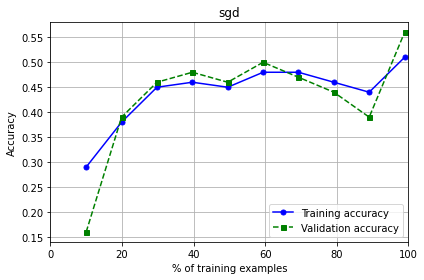

rms


  0%|          | 0/10 [00:00<?, ?it/s]

_____________________________________________________________________________
train_sizes= 0.1
Training accuracy= 0.55 ; Validation accuracy= 0.49
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.1988888888888889
Training accuracy= 0.55 ; Validation accuracy= 0.5
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.2977777777777778
Training accuracy= 0.56 ; Validation accuracy= 0.52
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.3966666666666666
Training accuracy= 0.54 ; Validation accuracy= 0.51
_____________________________________________________________________________
________________________________________________________

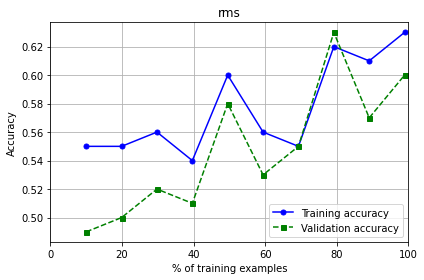

adam


  0%|          | 0/10 [00:00<?, ?it/s]

_____________________________________________________________________________
train_sizes= 0.1
Training accuracy= 0.58 ; Validation accuracy= 0.47
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.1988888888888889
Training accuracy= 0.59 ; Validation accuracy= 0.54
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.2977777777777778
Training accuracy= 0.54 ; Validation accuracy= 0.49
_____________________________________________________________________________
_____________________________________________________________________________
train_sizes= 0.3966666666666666
Training accuracy= 0.6 ; Validation accuracy= 0.59
_____________________________________________________________________________
________________________________________________________

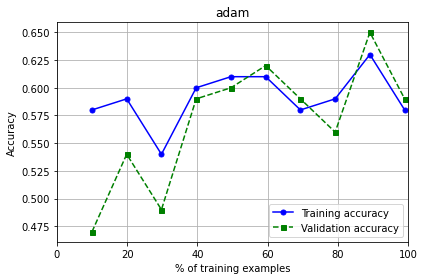

In [ ]:
for optimizer_name, optimizer in optimizers.items():
    print(optimizer_name)
    train_scores, test_scores = modelfit(optimizer)   
    train_sizes = [i for i in np.linspace(0.1, 0.99, 10)]
    
    plt.title(optimizer_name)
    plt.plot(np.array(train_sizes)*100, train_scores,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

    plt.plot(np.array(train_sizes)*100, test_scores,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

    plt.grid()
    plt.xlabel('% of training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.xlim([0, 100])
    plt.tight_layout()
    plt.show()

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [ ]:
model_z_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model_z_1.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_z_1.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 48s 38ms/step - loss: 2.0428 - accuracy: 0.2580 - val_loss: 1.7928 - val_accuracy: 0.3696
Epoch 2/15
1250/1250 [==============================] - 46s 37ms/step - loss: 1.6846 - accuracy: 0.4027 - val_loss: 1.5636 - val_accuracy: 0.4420
Epoch 3/15
1250/1250 [==============================] - 44s 35ms/step - loss: 1.5078 - accuracy: 0.4617 - val_loss: 1.4410 - val_accuracy: 0.4869
Epoch 4/15
1250/1250 [==============================] - 43s 34ms/step - loss: 1.4219 - accuracy: 0.4902 - val_loss: 1.4098 - val_accuracy: 0.4994
Epoch 5/15
1250/1250 [==============================] - 43s 34ms/step - loss: 1.3583 - accuracy: 0.5134 - val_loss: 1.3369 - val_accuracy: 0.5298
Epoch 6/15
1250/1250 [==============================] - 44s 35ms/step - loss: 1.3026 - accuracy: 0.5353 - val_loss: 1.2830 - val_accuracy: 0.5524
Epoch 7/15
1250/1250 [==============================] - 43s 34ms/step - loss: 1.2580 - accuracy: 0.5527 - val_loss: 1.2907 -

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 5s 16ms/step

 Test_acc = 0.0792


**Жесть**

Фильтры в первом слое до 20

In [ ]:
model_z_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model_z_2.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_z_2.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 65s 51ms/step - loss: 2.0206 - accuracy: 0.2618 - val_loss: 1.7820 - val_accuracy: 0.3577
Epoch 2/15
1250/1250 [==============================] - 69s 55ms/step - loss: 1.6941 - accuracy: 0.3909 - val_loss: 1.6492 - val_accuracy: 0.4050
Epoch 3/15
1250/1250 [==============================] - 63s 51ms/step - loss: 1.5352 - accuracy: 0.4474 - val_loss: 1.4991 - val_accuracy: 0.4613
Epoch 4/15
1250/1250 [==============================] - 62s 50ms/step - loss: 1.4555 - accuracy: 0.4766 - val_loss: 1.4613 - val_accuracy: 0.4801
Epoch 5/15
1250/1250 [==============================] - 60s 48ms/step - loss: 1.3957 - accuracy: 0.5016 - val_loss: 1.4026 - val_accuracy: 0.5003
Epoch 6/15
1250/1250 [==============================] - 61s 49ms/step - loss: 1.3445 - accuracy: 0.5195 - val_loss: 1.3213 - val_accuracy: 0.5248
Epoch 7/15
1250/1250 [==============================] - 61s 49ms/step - loss: 1.2966 - accuracy: 0.5378 - val_loss: 1.3046 -

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 4s 14ms/step

 Test_acc = 0.0792


**Ладно, пусть будет размер свёрточного ядра - 9 **

In [ ]:
model_z_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(9, 9),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model_z_3.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_z_3.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 109s 87ms/step - loss: 1.9927 - accuracy: 0.2685 - val_loss: 1.7413 - val_accuracy: 0.3813
Epoch 2/15
1250/1250 [==============================] - 107s 85ms/step - loss: 1.6973 - accuracy: 0.3952 - val_loss: 1.6496 - val_accuracy: 0.4185
Epoch 3/15
1250/1250 [==============================] - 106s 85ms/step - loss: 1.5520 - accuracy: 0.4443 - val_loss: 1.5233 - val_accuracy: 0.4550
Epoch 4/15
1250/1250 [==============================] - 105s 84ms/step - loss: 1.4542 - accuracy: 0.4781 - val_loss: 1.4298 - val_accuracy: 0.4875
Epoch 5/15
1250/1250 [==============================] - 112s 89ms/step - loss: 1.3859 - accuracy: 0.5020 - val_loss: 1.4275 - val_accuracy: 0.4951
Epoch 6/15
1250/1250 [==============================] - 106s 85ms/step - loss: 1.3270 - accuracy: 0.5253 - val_loss: 1.3180 - val_accuracy: 0.5337
Epoch 7/15
1250/1250 [==============================] - 107s 86ms/step - loss: 1.2788 - accuracy: 0.5436 - val_loss: 1

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 4s 12ms/step

 Test_acc = 0.0792


**никаких измененй**

количество входов в первом Dense слое до 64

In [ ]:
model_z_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model_z_4.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_z_4.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 81s 64ms/step - loss: 1.9912 - accuracy: 0.2817 - val_loss: 1.7251 - val_accuracy: 0.3880
Epoch 2/15
1250/1250 [==============================] - 78s 63ms/step - loss: 1.6117 - accuracy: 0.4240 - val_loss: 1.5017 - val_accuracy: 0.4575
Epoch 3/15
1250/1250 [==============================] - 78s 62ms/step - loss: 1.4620 - accuracy: 0.4791 - val_loss: 1.5085 - val_accuracy: 0.4674
Epoch 4/15
1250/1250 [==============================] - 84s 67ms/step - loss: 1.3766 - accuracy: 0.5091 - val_loss: 1.3481 - val_accuracy: 0.5265
Epoch 5/15
1250/1250 [==============================] - 83s 66ms/step - loss: 1.3130 - accuracy: 0.5346 - val_loss: 1.3482 - val_accuracy: 0.5223
Epoch 6/15
1250/1250 [==============================] - 81s 65ms/step - loss: 1.2567 - accuracy: 0.5558 - val_loss: 1.2845 - val_accuracy: 0.5440
Epoch 7/15
1250/1250 [==============================] - 78s 62ms/step - loss: 1.2067 - accuracy: 0.5741 - val_loss: 1.2600 -

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 4s 12ms/step

 Test_acc = 0.0792


dropout в 20%

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 105s 83ms/step - loss: 2.0332 - accuracy: 0.2474 - val_loss: 1.7470 - val_accuracy: 0.3663
Epoch 2/60
1250/1250 [==============================] - 101s 81ms/step - loss: 1.6886 - accuracy: 0.3863 - val_loss: 1.5534 - val_accuracy: 0.4411
Epoch 3/60
1250/1250 [==============================] - 117s 94ms/step - loss: 1.5475 - accuracy: 0.4374 - val_loss: 1.5034 - val_accuracy: 0.4634
Epoch 4/60
1250/1250 [==============================] - 101s 81ms/step - loss: 1.4636 - accuracy: 0.4726 - val_loss: 1.3801 - val_accuracy: 0.5079
Epoch 5/60
1250/1250 [==============================] - 104s 83ms/step - loss: 1.4078 - accuracy: 0.4917 - val_loss: 1.3296 - val_accuracy: 0.5265
Epoch 6/60
1250/1250 [==============================] - 103s 83ms/step - loss: 1.3566 - accuracy: 0.5107 - val_loss: 1.2954 - val_accuracy: 0.5328
Epoch 7/60
1250/1250 [==============================] - 101s 80ms/step - loss: 1.3158 - accuracy: 0.5281 - val_loss: 1

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 8s 24ms/step

 Test_acc = 0.6963


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

**аааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааааа   регрессии и деревья лучше**